# Risk & Finance Management - Kelompok 9

## Import Library

In [1]:
# Import Library

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

## Import Data

In [2]:
df = pd.read_csv("..\Loan_status_2007-2020Q3.csv", nrows=1000000)

C:\Users\User\AppData\Local\Temp\ipykernel_5912\2261176854.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("..\Loan_status_2007-2020Q3.csv", nrows=1000000)


In [3]:
needed_columns = [
    "loan_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",
    "emp_length",
    "home_ownership",
    "issue_d",
    "verification_status",
    "purpose",
    "dti",
    "delinq_2yrs",
    "loan_status",
    "zip_code",
    "avg_cur_bal",
    "revol_bal",
]
df = df[needed_columns]
print(df.head())

   loan_amnt        term int_rate  installment grade sub_grade emp_length  \
0     5000.0   36 months   10.65%       162.87     B        B2  10+ years   
1     2500.0   60 months   15.27%        59.83     C        C4   < 1 year   
2     2400.0   36 months   15.96%        84.33     C        C5  10+ years   
3    10000.0   36 months   13.49%       339.31     C        C1  10+ years   
4     3000.0   60 months   12.69%        67.79     B        B5     1 year   

  home_ownership   issue_d verification_status         purpose    dti  \
0           RENT  Dec-2011            Verified     credit_card  27.65   
1           RENT  Dec-2011     Source Verified             car   1.00   
2           RENT  Dec-2011        Not Verified  small_business   8.72   
3           RENT  Dec-2011     Source Verified           other  20.00   
4           RENT  Dec-2011     Source Verified           other  17.94   

   delinq_2yrs  loan_status zip_code  avg_cur_bal  revol_bal  
0          0.0   Fully Paid    860x

## Pre-Processing

In [4]:
df = df.dropna()
print("\nNull value count")
for col in needed_columns:
    print("{} = {}".format(col, df[col].isnull().sum()))


Null value count
loan_amnt = 0
term = 0
int_rate = 0
installment = 0
grade = 0
sub_grade = 0
emp_length = 0
home_ownership = 0
issue_d = 0
verification_status = 0
purpose = 0
dti = 0
delinq_2yrs = 0
loan_status = 0
zip_code = 0
avg_cur_bal = 0
revol_bal = 0


In [5]:
## Interest rate
df["int_rate"] = df["int_rate"].str.replace("%", "").str.strip().astype(float)

## Term
df["term"] = df["term"].str.replace("months", "").str.strip().astype(int)

In [6]:
print(df.head())

       loan_amnt  term  int_rate  installment grade sub_grade emp_length  \
42536    12000.0    36     10.99       392.81     B        B2    4 years   
42537     4800.0    36     10.99       157.13     B        B2    2 years   
42538    27050.0    36     10.99       885.46     B        B2  10+ years   
42539    12000.0    36      7.62       373.94     A        A3    3 years   
42540    14000.0    36     12.85       470.71     B        B4    4 years   

      home_ownership   issue_d verification_status             purpose    dti  \
42536           RENT  Dec-2013        Not Verified  debt_consolidation   4.62   
42537       MORTGAGE  Dec-2013     Source Verified    home_improvement   2.49   
42538            OWN  Dec-2013            Verified  debt_consolidation  22.87   
42539       MORTGAGE  Dec-2013        Not Verified  debt_consolidation  12.61   
42540           RENT  Dec-2013        Not Verified  debt_consolidation  10.02   

       delinq_2yrs loan_status zip_code  avg_cur_bal  re

## Exploratory Data Analysis

<Axes: title={'center': 'Loan Status Values for Lending Club'}>

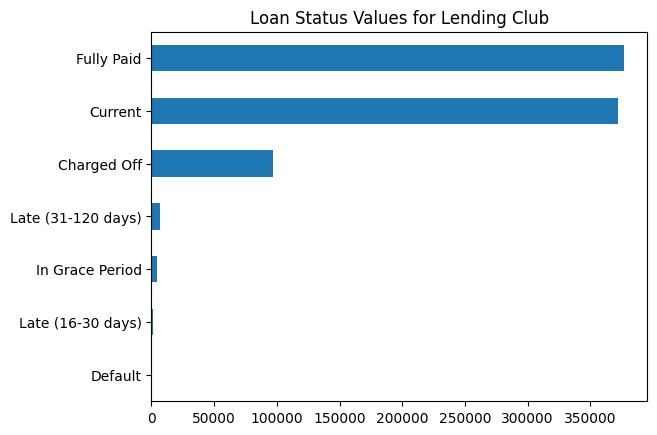

In [7]:
df["loan_status"].dropna().value_counts().sort_values().plot(
    kind="barh", title="Loan Status Values for Lending Club"
)

<Axes: title={'center': 'Loan Grades for Lending Club'}>

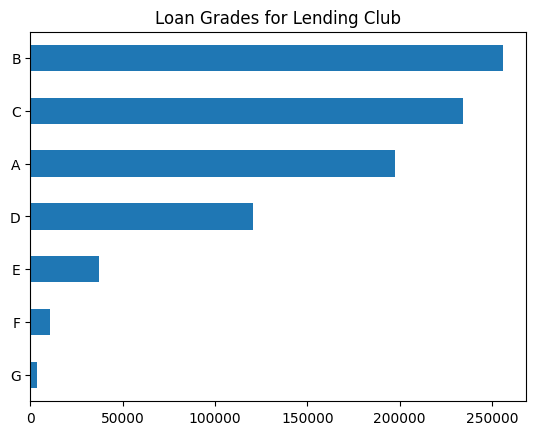

In [8]:
df["grade"].value_counts().sort_values().plot(
    kind="barh", title="Loan Grades for Lending Club"
)

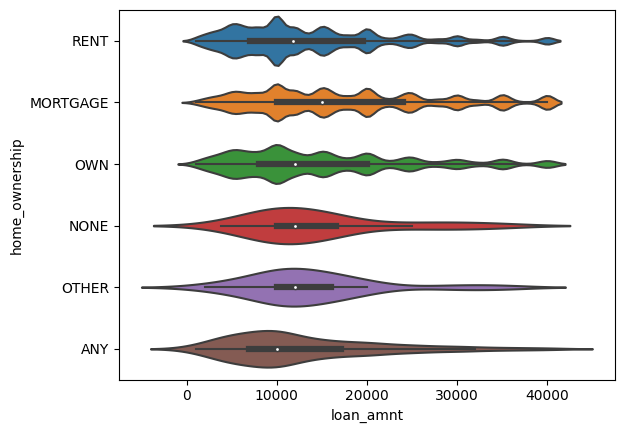

In [9]:
sns.violinplot(x="loan_amnt", y="home_ownership", data=df)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

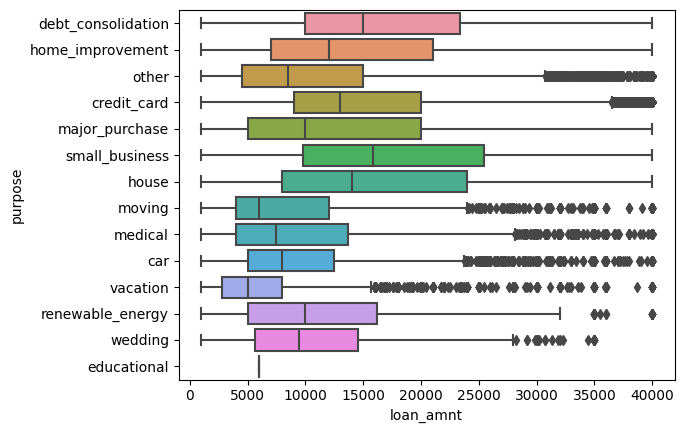

In [10]:
sns.boxplot(x="loan_amnt", y="purpose", data=df)
plt.show

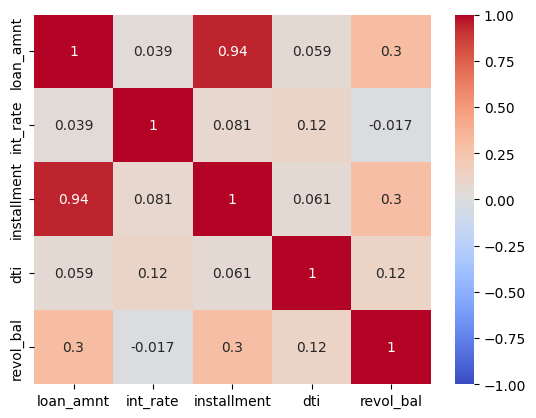

In [11]:
numeric_df = df[["loan_amnt", "int_rate", "installment", "dti", "revol_bal"]]
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

In [12]:
df["loan_status"] = df["loan_status"].apply(lambda status: 'yes' if status in ['Charged Off', 'Default', 'Late (31-120 days)', 'Late (16-30 days)'] else 'no')

In [13]:
le = LabelEncoder()
df["emp_length"] = le.fit_transform(df["emp_length"])
df["grade"] = le.fit_transform(df["grade"])
df["sub_grade"] = le.fit_transform(df["sub_grade"])
df["home_ownership"] = le.fit_transform(df["home_ownership"])
df["issue_d"] = le.fit_transform(df["issue_d"])
df["verification_status"] = le.fit_transform(df["verification_status"])
df["purpose"] = le.fit_transform(df["purpose"])
df["loan_status"] = le.fit_transform(df["loan_status"])
df["zip_code"] = le.fit_transform(df["zip_code"])

## Modelling

### Decision Tree

In [14]:
X = df.drop("loan_status", axis=1)  # Features
y = df["loan_status"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [15]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

print("Decision Tree Accuracy:", accuracy_dt)
print("Decision Tree Precision:", precision_dt)
print("Decision Tree Recall:", recall_dt)
print("Decision Tree F1-Score:", f1_dt)

Decision Tree Accuracy: 0.7841658227307825
Decision Tree Precision: 0.17131659723744794
Decision Tree Recall: 0.19757261607509718
Decision Tree F1-Score: 0.18351020887460187


In [16]:
print(
    "Decision Tree Classification Report:\n", classification_report(y_test, y_pred_dt)
)

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88    226082
           1       0.17      0.20      0.18     31639

    accuracy                           0.78    257721
   macro avg       0.53      0.53      0.53    257721
weighted avg       0.80      0.78      0.79    257721



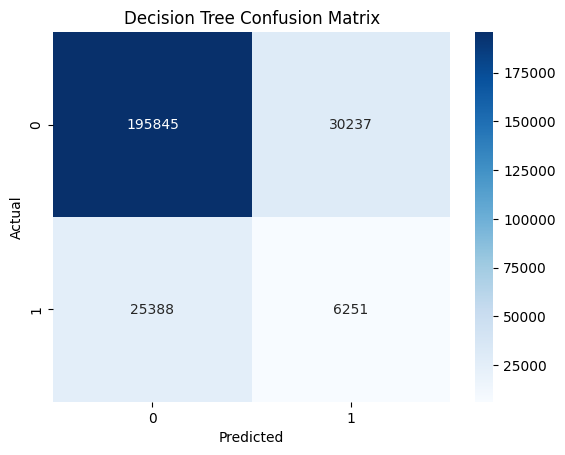

In [17]:
cm_dt = confusion_matrix(y_test, y_pred_dt)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Random Forest

In [19]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [20]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Random Forest Accuracy:", accuracy_rf)
print("Random Forest Precision:", precision_rf)
print("Random Forest Recall:", recall_rf)
print("Random Forest F1-Score:", f1_rf)

Random Forest Accuracy: 0.8767543195936691
Random Forest Precision: 0.4049079754601227
Random Forest Recall: 0.00834413224185341
Random Forest F1-Score: 0.016351305317271067


In [21]:
print(
    "Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf)
)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    226082
           1       0.40      0.01      0.02     31639

    accuracy                           0.88    257721
   macro avg       0.64      0.50      0.48    257721
weighted avg       0.82      0.88      0.82    257721



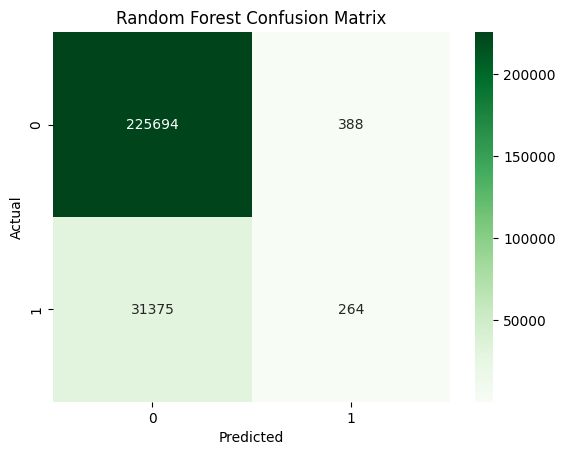

In [22]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### XGBoost

In [23]:
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [24]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("XGBoost Accuracy:", accuracy_xgb)
print("XGBoost Precision:", precision_xgb)
print("XGBoost Recall:", recall_xgb)
print("XGBoost F1-Score:", f1_xgb)

XGBoost Accuracy: 0.8769987699876999
XGBoost Precision: 0.4497528830313015
XGBoost Recall: 0.008628591295552957
XGBoost F1-Score: 0.016932332692426968


In [25]:
print(
    "XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb)
)

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    226082
           1       0.45      0.01      0.02     31639

    accuracy                           0.88    257721
   macro avg       0.66      0.50      0.48    257721
weighted avg       0.83      0.88      0.82    257721



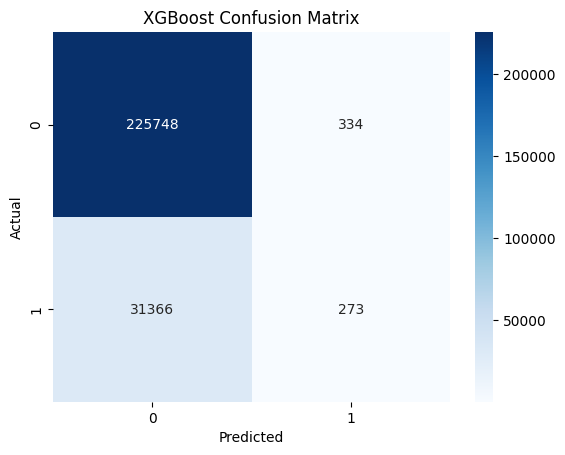

In [26]:
cm_dt = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Logistic Regression

In [27]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)

In [28]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Precision:", precision_lr)
print("Logistic Regression Recall:", recall_lr)
print("Logistic Regression F1-Score:", f1_lr)

Logistic Regression Accuracy: 0.8762149766608076
Logistic Regression Precision: 0.281198003327787
Logistic Regression Recall: 0.005341508897247068
Logistic Regression F1-Score: 0.010483870967741936


In [29]:
print(
    "Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr)
)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93    226082
           1       0.28      0.01      0.01     31639

    accuracy                           0.88    257721
   macro avg       0.58      0.50      0.47    257721
weighted avg       0.80      0.88      0.82    257721



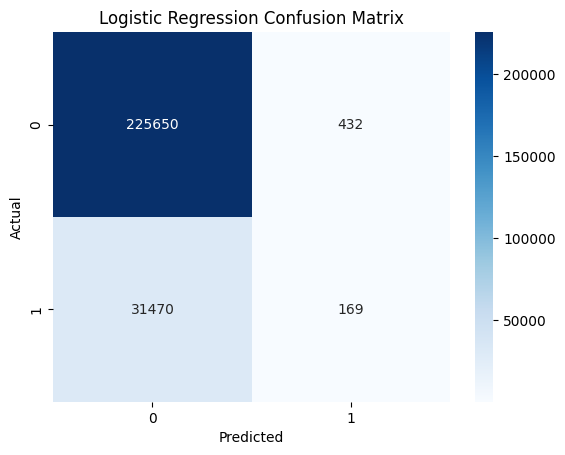

In [30]:
cm_dt = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm_dt, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()